In [1]:
# Config & imports

import os, re, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras

# ---- Paths (adapt as needed) ----
MODEL_PATH    = "../data/models/mlp/ann_mlp.keras"
SCALER_NPZ    = "../data/models/mlp/scaler_mean_std.npz"  
WN_FROM_NPZ   = "../generated/bulk_50k/shard_000.npz"        
PRED_DIR      = "../sample"                         
MANIFEST_CSV  = "../generated/grid_100/grid_manifest.CSV"     
PROFILE_CSV   = "../data/refs/profile.CSV"            
OUT_DIR       = "../results"
PLOT_DIR      = "../plots"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Output filenames ----
PRED_CSV      = os.path.join(OUT_DIR, "mlp_pred.csv")
PARITY_JPG    = os.path.join(PLOT_DIR, "fig_s3c.jpg")
HIST_JPG      = os.path.join(PLOT_DIR, "fig_s3d.jpg")
RESID_JPG     = os.path.join(PLOT_DIR, "fig_s3f.jpg")
MAP_JPG       = os.path.join(PLOT_DIR, "fig_s3e.jpg")

print("Config OK")


2026-02-09 19:42:58.079457: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 19:42:58.153706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Config OK


2026-02-09 19:42:59.539375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Load model, scaler, and wn (grid)

model = keras.models.load_model(MODEL_PATH)

sc = np.load(SCALER_NPZ)
scaler_mean = sc["mean"].astype(np.float32)
scaler_std  = sc["std"].astype(np.float32)

shard0 = np.load(WN_FROM_NPZ)
wn = shard0["wn"].astype(np.float32)
N_POINTS = wn.shape[0]

print("Loaded model:", MODEL_PATH)
print("Scaler keys:", sc.files, "| mean/std shape:", scaler_mean.shape, scaler_std.shape)
print("wn points:", N_POINTS, "| wn[0..3]:", wn[:3])


I0000 00:00:1770633779.847217 1914721 gpu_device.cc:2411] Ignoring visible gpu device (device: 4, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
I0000 00:00:1770633780.189717 1914721 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1086 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:31:00.0, compute capability: 8.6
I0000 00:00:1770633780.190412 1914721 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22297 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:4b:00.0, compute capability: 8.6
I0000 00:00:1770633780.190981 1914721 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22297 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:b1:00.0, compute capability: 8.6
I0000 0

Loaded model: ../data/models/mlp/ann_mlp.keras
Scaler keys: ['mean', 'std'] | mean/std shape: (3323,) (3323,)
wn points: 3323 | wn[0..3]: [677. 678. 679.]


In [3]:
# Helper functions

def load_spectrum_csv(path: str):
    df = pd.read_csv(path, header=None)
    x = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
    y = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
    m = ~(np.isnan(x) | np.isnan(y))
    return x[m].astype(np.float32), y[m].astype(np.float32)

def to_model_input(x, y):
    # 1) interpolate to training grid
    f  = interp1d(x, y, kind="linear", bounds_error=False, fill_value="extrapolate")
    yg = f(wn).astype(np.float32)

    # 2) (same as training) — standardize with training mean/std
    ys = (yg - scaler_mean) / (scaler_std + 1e-12)
    return ys

def parse_run_id_from_name(fn: str):
    """Extract trailing digits before extension, e.g., sample_0123.csv -> 123"""
    m = re.search(r'(\d+)(?=\.[Cc][Ss][Vv]$)', os.path.basename(fn))
    return int(m.group(1)) if m else None


In [4]:
# Batch predict PRED_DIR CSVs

files = sorted([os.path.join(PRED_DIR, f) for f in os.listdir(PRED_DIR)
                if f.lower().endswith(".csv")])
if not files:
    raise SystemExit(f"No CSV files found in {PRED_DIR}")

rows = []
for fp in files:
    try:
        x, y = load_spectrum_csv(fp)
        xin = to_model_input(x, y)
        yhat = float(model.predict(xin[None, ...], verbose=0).ravel()[0])
        rows.append(dict(file=os.path.basename(fp), pred_hbn_percent=yhat))
    except Exception as e:
        rows.append(dict(file=os.path.basename(fp), pred_hbn_percent=np.nan))
        print("Failed:", fp, "|", e)

pred_df = pd.DataFrame(rows).copy()
pred_df["run_id"] = pred_df["file"].apply(parse_run_id_from_name)
pred_df.to_csv(PRED_CSV, index=False)
print("Saved predictions →", PRED_CSV)
pred_df.head(10)


2026-02-09 19:43:01.518971: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f24f4004f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-09 19:43:01.519014: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2026-02-09 19:43:01.519022: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2026-02-09 19:43:01.519029: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (2): NVIDIA RTX A5000, Compute Capability 8.6
2026-02-09 19:43:01.519035: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (3): NVIDIA RTX A5000, Compute Capability 8.6
2026-02-09 19:43:01.529960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-09 19:43:01.558588: I exter

Saved predictions → ../results/mlp_pred.csv


,file,pred_hbn_percent,run_id
0,ptfe100_hbn00_002.CSV,2.185451,2
1,ptfe100_hbn00_005.CSV,2.261343,5
2,ptfe100_hbn00_006.CSV,2.189906,6
3,ptfe100_hbn00_008.CSV,2.321600,8
4,ptfe100_hbn00_009.CSV,2.149443,9
5,ptfe100_hbn00_010.CSV,2.251879,10
6,ptfe100_hbn00_011.CSV,2.114862,11
7,ptfe100_hbn00_013.CSV,2.401974,13
8,ptfe100_hbn00_015.CSV,2.304424,15
9,ptfe100_hbn00_017.CSV,2.323638,17


In [5]:
# Merge ground truth (manifest)

man = pd.read_csv(MANIFEST_CSV).copy()

# ensure an 'index' column
if "index" not in man.columns:
    man["index"] = np.arange(1, len(man)+1, dtype=int)

# harmonize hBN column name
if "hbn_percent" in man.columns:
    man = man.rename(columns={"hbn_percent": "hbn_percent_true"})
elif "ptfe_percent" in man.columns:
    man = man.rename(columns={"ptfe_percent": "ptfe_percent_true"})
    man["hbn_percent_true"] = 100.0 - man["ptfe_percent_true"]
else:
    raise KeyError("Manifest must have 'hbn_percent' or 'ptfe_percent' column.")

# try to merge by index (if filenames encode run_id == index)
df = pred_df.copy()
if df["run_id"].notna().any():
    df = df.merge(man[["index","hbn_percent_true"]], left_on="run_id", right_on="index", how="left")
else:
    # fallback: attempt merge by basename if manifest has filename column (rare)
    if "file" in man.columns:
        df = df.merge(man[["file","hbn_percent_true"]], on="file", how="left")
    else:
        print("Warning: couldn't align to manifest by run_id; 'hbn_percent_true' may be NaN.")

print("Merged rows:", len(df), "| known GT:", df["hbn_percent_true"].notna().sum())
df.head(10)


Merged rows: 100 | known GT: 100


,file,pred_hbn_percent,run_id,index,hbn_percent_true
0,ptfe100_hbn00_002.CSV,2.185451,2,2,0
1,ptfe100_hbn00_005.CSV,2.261343,5,5,0
2,ptfe100_hbn00_006.CSV,2.189906,6,6,0
3,ptfe100_hbn00_008.CSV,2.321600,8,8,0
4,ptfe100_hbn00_009.CSV,2.149443,9,9,0
5,ptfe100_hbn00_010.CSV,2.251879,10,10,0
6,ptfe100_hbn00_011.CSV,2.114862,11,11,0
7,ptfe100_hbn00_013.CSV,2.401974,13,13,0
8,ptfe100_hbn00_015.CSV,2.304424,15,15,0
9,ptfe100_hbn00_017.CSV,2.323638,17,17,0


Metrics | MAE=1.951  RMSE=2.052  R²=0.970
Saved: ../results/mlp_pred-gt.csv


/tmp/ipykernel_1914721/3341814437.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=FONT-2, frameon=False)


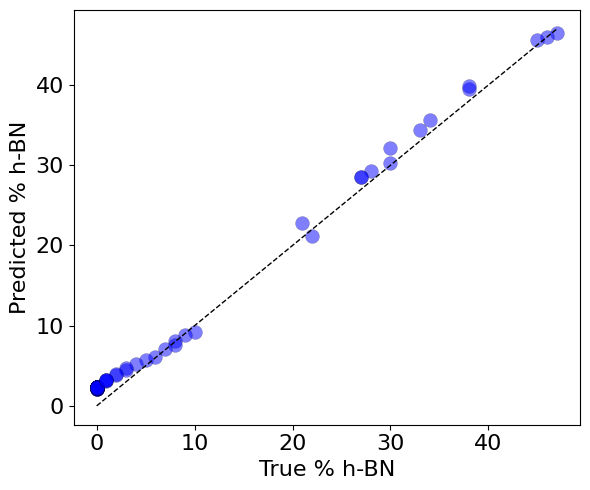

Saved: ../plots/fig_s3c.jpg


In [6]:
# Parity plot (pred vs true) + metrics + save

# ---- Viz style ----
FIGSIZE_PARITY = (6, 5)
FIGSIZE_HIST   = (6, 5)
DPI            = 500
FONT           = 16
SCATTER_ALPHA  = 0.5
SCATTER_SIZE   = 100
EDGE_W         = 0.2

mask = df["hbn_percent_true"].notna()
y_true = df.loc[mask, "hbn_percent_true"].to_numpy(float)
y_pred = df.loc[mask, "pred_hbn_percent"].to_numpy(float)

if len(y_true) > 0:
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"Metrics | MAE={mae:.3f}  RMSE={rmse:.3f}  R²={r2:.3f}")
else:
    mae = rmse = r2 = np.nan
    print("No ground truth found to compute metrics.")

# save merged CSV (pred + GT)
MERGED_CSV = os.path.join(OUT_DIR, "mlp_pred-gt.csv")
df.to_csv(MERGED_CSV, index=False)
print("Saved:", MERGED_CSV)

# parity plot
if len(y_true) > 0:
    plt.figure(figsize=FIGSIZE_PARITY)
    plt.scatter(y_true, y_pred, color="blue", alpha=SCATTER_ALPHA,
                s=SCATTER_SIZE, edgecolor="k", linewidth=EDGE_W)
    mn = float(min(y_true.min(), y_pred.min()))
    mx = float(max(y_true.max(), y_pred.max()))
    plt.plot([mn, mx], [mn, mx], "k--", lw=1)
    plt.xlabel("True % h-BN", fontsize=FONT)
    plt.ylabel("Predicted % h-BN", fontsize=FONT)
    plt.xticks(fontsize=FONT); plt.yticks(fontsize=FONT)
    plt.legend(fontsize=FONT-2, frameon=False)
    plt.tight_layout()
    plt.savefig(PARITY_JPG, dpi=DPI)
    plt.show()
    print("Saved:", PARITY_JPG)


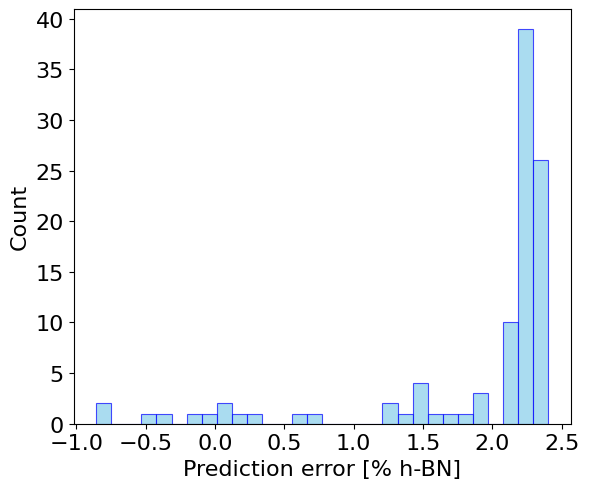

Saved: ../plots/fig_s3d.jpg


In [7]:
# Error histogram & residual vs. true

err = y_pred - y_true

# histogram
plt.figure(figsize=FIGSIZE_HIST)

# parameters
HIST_COLOR   = "skyblue"   # fill color
EDGE_COLOR   = "blue"        # outline color
ALPHA        = 0.7            # transparency (0=transparent, 1=solid)
BINS         = 30

plt.hist(
    err,
    bins=BINS,
    color=HIST_COLOR,
    edgecolor=EDGE_COLOR,
    alpha=ALPHA,
    linewidth=0.8
)

plt.xlabel("Prediction error [% h-BN]", fontsize=FONT)
plt.ylabel("Count", fontsize=FONT)
plt.xticks(fontsize=FONT)
plt.yticks(fontsize=FONT)
plt.tight_layout()

plt.savefig(HIST_JPG, dpi=DPI)
plt.show()
print("Saved:", HIST_JPG)


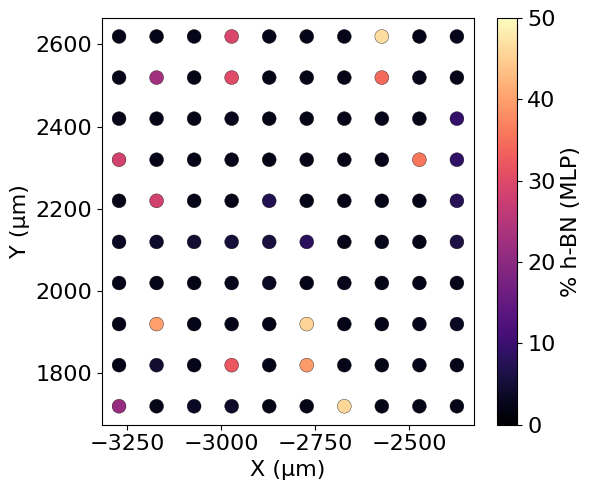

Saved: ../plots/fig_s3e.jpg


In [8]:

# XY alignment (last 3 digits) + map (once)

import re
from matplotlib.ticker import MaxNLocator

def last3_idx(fn: str):
    m = re.search(r'(\d{3})(?=\.[Cc][Ss][Vv]$)', os.path.basename(fn))
    return int(m.group(1)) if m else None

# 1) order predictions by last 3 digits (001..100)
df_ord = df.copy()
df_ord["order3"] = df_ord["file"].apply(last3_idx)
df_ord = df_ord.dropna(subset=["order3"]).sort_values("order3").reset_index(drop=True)

# 2) load profile (assumed already sorted 001..100)
prof = pd.read_csv(PROFILE_CSV, header=None, usecols=[0,1], names=["X","Y"])
n_map = min(len(prof), len(df_ord))

# 3) align in order
df_map = df_ord.iloc[:n_map].copy()
df_map["X"] = prof.loc[:n_map-1, "X"].to_numpy()
df_map["Y"] = prof.loc[:n_map-1, "Y"].to_numpy()

# 4) continuous h-BN% prediction map (single plot, no loop)
plt.figure(figsize=(6,5))
sc = plt.scatter(df_map["X"], df_map["Y"],
                 c=df_map["pred_hbn_percent"],
                 vmin = 0, vmax = 50,
                 cmap="magma", s=100, edgecolor="k", linewidth=0.25, zorder=2)
# plt.scatter(df_map["X"], df_map["Y"], c="k", s=100, zorder=1)  # background grid
cbar = plt.colorbar(sc)
cbar.set_label("% h-BN (MLP)", fontsize=FONT)
cbar.ax.tick_params(labelsize=FONT)
plt.xlabel("X (µm)", fontsize=FONT); plt.ylabel("Y (µm)", fontsize=FONT)
plt.xticks(fontsize=FONT); plt.yticks(fontsize=FONT)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.savefig(MAP_JPG, dpi=DPI)
plt.show()
print("Saved:", MAP_JPG)


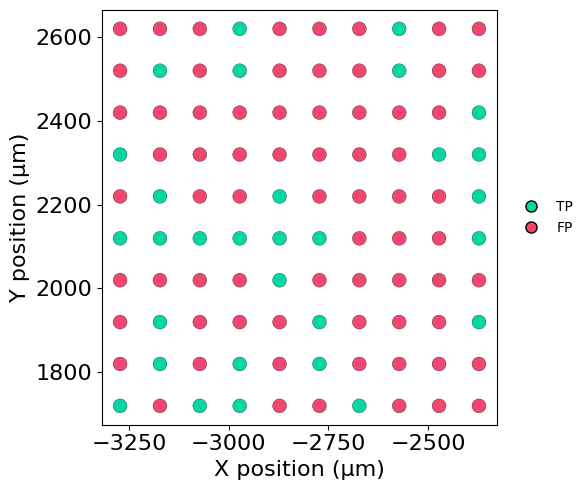

Saved: ../plots/fig_s3f.jpg


In [14]:
# =====================================================
# Cell — TN/FP/FN/TP map (binary presence)
# =====================================================
from matplotlib.lines import Line2D

# --- thresholds (edit here) ---
GT_IMPURITY_MIN    = 1.0   # % h-BN in GT counted as impurity
PRED_IMPURITY_MIN  = 1.0   # % h-BN predicted counted as impurity

# --- local style controls ---
FIGSIZE   = (6, 5)
DPI_LOCAL = 500
FONT_L    = 16
MSIZE     = 100
EDGE_W    = 0.2
GRID_SIZE = 80

# compute labels where GT known (use the XY-aligned df_map)
df2 = df_map.copy()
valid = ~np.isnan(df2.get("hbn_percent_true", np.nan))

# if df_map lost GT during ordering, merge it back from original df (by file)
if "hbn_percent_true" not in df2.columns or df2["hbn_percent_true"].isna().all():
    df2 = df_map.merge(df[["file","hbn_percent_true"]], on="file", how="left")
    valid = ~np.isnan(df2["hbn_percent_true"])

df2["gt_impurity"]   = np.where(valid, (df2["hbn_percent_true"] >= GT_IMPURITY_MIN).astype(int), -1)
df2["pred_impurity"] = (df2["pred_hbn_percent"] >= PRED_IMPURITY_MIN).astype(int)

# category codes: -1=unknown GT, 0=TN, 1=FP, 2=FN, 3=TP
cat = np.full(len(df2), -1, dtype=int)
mask_v = valid
cat[(mask_v) & (df2["gt_impurity"]==0) & (df2["pred_impurity"]==0)] = 0  # TN
cat[(mask_v) & (df2["gt_impurity"]==0) & (df2["pred_impurity"]==1)] = 1  # FP
cat[(mask_v) & (df2["gt_impurity"]==1) & (df2["pred_impurity"]==0)] = 2  # FN
cat[(mask_v) & (df2["gt_impurity"]==1) & (df2["pred_impurity"]==1)] = 3  # TP

palette    = { -1:"#CCCCCC", 0:"#26547c", 1:"#ef476f", 2:"#ffd166", 3:"#06d6a0" }
labels  = { -1:"Unknown GT", 0:"TN", 1:"FP", 2:"FN", 3:"TP" }

plt.figure(figsize=FIGSIZE)

# draw grid (background)
# plt.scatter(df2["X"], df2["Y"], c="k", s=GRID_SIZE, zorder=1)

# overlay categorized points
colors = [palette[v] for v in cat]
plt.scatter(df2["X"], df2["Y"], c=colors, s=MSIZE, edgecolor="k", linewidth=EDGE_W, zorder=2)

plt.xlabel("X position (µm)", fontsize=FONT_L)
plt.ylabel("Y position (µm)", fontsize=FONT_L)
plt.xticks(fontsize=FONT_L); plt.yticks(fontsize=FONT_L)

# legend (ordered)
order = [3,2,1,0,-1]
handles = [Line2D([0],[0], marker='o', color='w',
                  label=labels[k], markerfacecolor=palette[k],
                  markeredgecolor='k', markersize=8)
           for k in order if (cat==k).any()]
plt.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02,0.5), frameon=False)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.savefig(RESID_JPG, dpi=DPI)
plt.show()
print("Saved:", RESID_JPG)
